# Estimate transient forcing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../Data_processing/')

from estimation import *
from plotting_functions import *
from processing_functions import *

#import importlib
#import my_functions as f
#importlib.reload(f) # needed to load new changes in my_functions
#import warnings
#warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})

saveforcingdata = True # create one file for each model/member, combine them later if needed
saveforcingfigure = False
save_tasdiff = True
#saveforcingdata = False; saveforcingfigure = False; save_tasdiff = False


In [2]:
## Find models with abrupt-4xCO2 experiments 
## (necessary condition to make other forcing estimates)
## Currently, only models with this experiment exist in directory

experiments = {}
directory = '../Processed_data/Global_annual_anomalies/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']
model_names.sort()
model_names.remove('CIESM')
model_names.remove('CAS-ESM2-0')
model_names.remove('MIROC-ES2H')
#exp = 'abrupt-4xCO2'
#for model in model_names:
#    modeldirectory = os.path.join(directory, model)
#    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
#    if exp in modelexp_names:
#        experiments[model] = {}
#        experiments[model][exp] = find_members(model, exp)
#models = experiments.keys()


In [3]:
model_names[17]

'EC-Earth3'

Forcing estimates saved for FGOALS-g3 ssp585 r1i1p1f1
Forcing estimates saved for FGOALS-g3 ssp585 r2i1p1f1
Forcing estimates saved for FGOALS-g3 ssp585 r3i1p1f1
Forcing estimates saved for FGOALS-g3 ssp585 r4i1p1f1


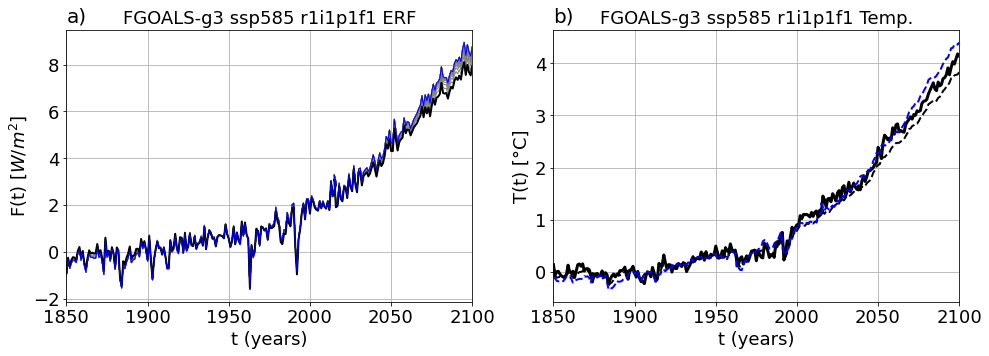

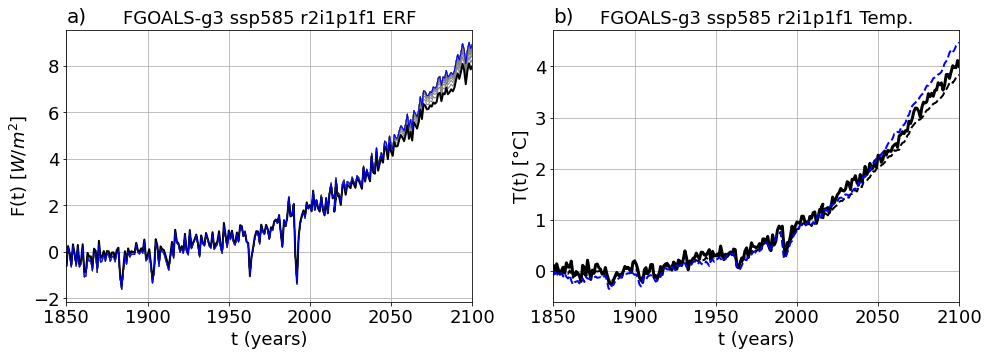

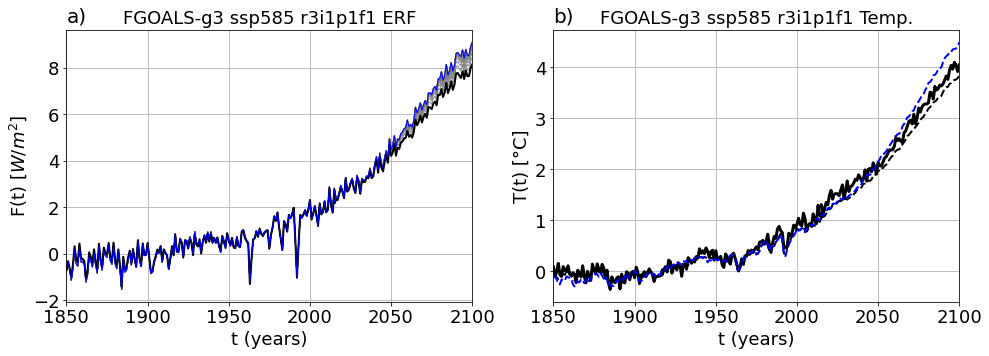

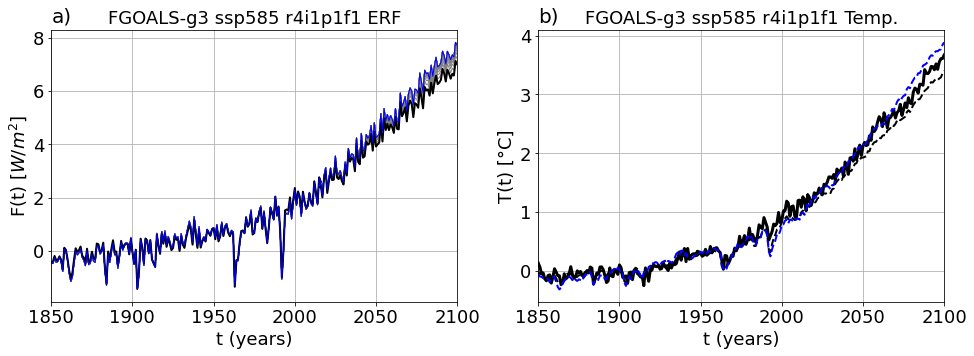

In [10]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']

# choose experiment:
#exp = '1pctCO2'
#exp = 'historical'
exp = 'ssp585'

#for model in model_names[0:]:
#for model in ['EC-Earth3']:
for model in ['FGOALS-g3']:
    if model not in ['EC-Earth3']:
        modeldirectory = os.path.join(directory, model)
        modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
        if exp in modelexp_names:
            members = find_members(model, exp)
        else:
            continue
            
        branch_time_file = '../Processed_data/Branch_times/' + model + '_branch_times.csv'
        table = pd.read_table(branch_time_file,index_col=0, sep = ',')
        pd.set_option('display.max_rows', None)
        branch_info_corrections(table, printing = False);
        exptable = table.loc[table['exp'] == exp]
        
        for member in members:
        #for member in ['r1i1p1f2']:
            member_df = exptable.loc[exptable['member'] == member]

            data = load_anom(model, exp, member)
            if data.empty:
                print('Empty dataframe for', model, exp, member)
                continue

            # if ssp experiment, then we need to include the response
            # generated by historical forcing
            # (for other experiments that branch from piControl,
            # previous forcing, and hence the temperature response
            # to previous forcing is supposed to be 0)
            if exp[:3] == 'ssp':
                # load historical data also and concatenate
                historical_members = find_members(model, 'historical')
                parent_member = member_df['parent_variant_id'].values[0]
                if parent_member in historical_members:
                    historical_data = load_anom(model, 'historical', parent_member)
                    data = pd.concat([historical_data, data])
                else:
                    print('Corresponding historical member does not exist for', model, exp, member)
                    continue
            if model == 'EC-Earth3': # data should start in 1970 after the previous if-test
                r_value = int(member.split("r")[1].split("i")[0])
                if r_value > 100: # happens only for historical and ssp experiments
                    # then historical exp starts in 1970, and we need to know the temperature response from its EC-Earth3-Veg parent
                    lens_parent_member = find_ECEarth3lens_parent(member)
                    historical_parent_data = load_anom('EC-Earth3-Veg', 'historical', lens_parent_member)
                    historical_parent_data = historical_parent_data[historical_parent_data.index < 1970]
                    data = pd.concat([historical_parent_data, data])

            years = data.index
            #years = np.arange(0, len(data));
            N = data['rsdt'] - data['rsut'] - data['rlut']
            if model == 'AWI-CM-1-1-MR':
                if exp[:3] == 'ssp' or exp == 'historical':
                    data['tas'][1850]=0 # set an approximate value since it does not exist for some reason...
            #variables = list(data)

            #plot_allvar_preloaded(years, data, model, member, plot_title = model + ' ' + exp + ' ' + member)
            #plot_tasandN(years, data['tas'], N, plot_title = model + ' ' + exp + ' ' + member)

            F = forcing_F13(data['tas'], N, model)

            # load parameters needed to make new forcing estimate:
            filename = 'best_estimated_parameters_allmembers.csv'

            parameter_table = pd.read_csv('../Estimates/' + filename, index_col=0)
            taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
            a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
            b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
            F2x = parameter_table.loc[model,'F2x']
            T2x = parameter_table.loc[model,'T2x']

            dim = len(taulist)
            if any(a_n == 0):
                dim = np.count_nonzero(a_n[:dim])
                zeroindex = np.where(a_n == 0)[0]
                a_n = np.delete(a_n,zeroindex)
                b_n = np.delete(b_n,zeroindex)
                taulist = np.delete(taulist,zeroindex)
            fbparlist = (b_n/a_n)[:dim]
            amplitudes = a_n[:dim]/(2*F2x*taulist)

            t = np.arange(0,len(F))
            #tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
            #Tn = amplitudes*tas_pred

            # Compute new estimate of forcing
            it = 20  # number of iterations
            Fiarray = np.full((len(F),it),np.nan)
            Tiarray = np.full((len(F),it),np.nan)

            Fi = F
            for i in range(0,it):
                tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                            timevaryingforcing = Fi)
                Tni = amplitudes*tas_pred
                Fi = N + Tni@fbparlist
                Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

            #plot_components(years, Tn, taulist)

            forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], titlestr = model + ' ' + exp + ' ' + member)

            if saveforcingfigure == True:
                plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
            #plt.close()

            if saveforcingdata == True:
                # create model directory if it does not already exist
                modelexpdir = os.path.join('../Estimates/Transient_forcing_estimates/', model, exp)
                if os.path.isdir(modelexpdir) == False:
                    os.makedirs(modelexpdir)
                index = pd.Index(years, name='Year')

                # save files
                if exp[:3] == 'ssp':
                    expstr = 'historicaland' + exp
                else:
                    expstr = exp
                df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
                modelfilename = model + '_' + expstr + '_' + member + '_F13_ERF.csv'
                df_F13.to_csv(modelexpdir + '/' + modelfilename)

                df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
                modelfilename = model + '_' + expstr + '_' + member + '_ERF.csv'
                df_F.to_csv(modelexpdir + '/' + modelfilename)
                print('Forcing estimates saved for', model, exp, member)

            if save_tasdiff == True:
                # save difference between linear response to new forcing and coupled model tas
                tas_diff = Tiarray[:,-1] - data['tas']
                index = pd.Index(years, name='Year')
                df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
                tas_filename = model + '_' + expstr + '_' + member + '_tas_diff.csv'
                df_tas.to_csv(modelexpdir + '/' + tas_filename)




In [14]:
member

'r9i1p1f2'

In [6]:
model

'AWI-CM-1-1-MR'